__Libraries__

In [97]:
# system tools
import os
import sys
sys.path.append(os.path.join(".."))

# pandas, numpy, gensim
import pandas as pd
import numpy as np
import gensim.downloader

# import my classifier utility functions - see the Github repo!
import utils.classifier_utils as clf

# Import plotting function and embedding matrix function
#import ass6_utils as utils

# Machine learning stuff
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit # cross-validation
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer

# tools from tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Embedding, 
                                     Flatten, GlobalMaxPool1D, Conv1D)
from tensorflow.keras.optimizers import SGD, Adam # optimization algorithms
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import L2 # regularization

# matplotlib
import matplotlib.pyplot as plt

In [98]:
def plot_history(H, epochs):
    """
    Utility function for plotting model history using matplotlib
    
    H: model history 
    epochs: number of epochs for which the model was trained
    """
    plt.style.use("fivethirtyeight")
    plt.figure()
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()
    

def create_embedding_matrix(filepath, word_index, embedding_dim):
    """ 
    A helper function to read in saved GloVe embeddings and create an embedding matrix
    
    filepath: path to GloVe embedding
    word_index: indices from keras Tokenizer
    embedding_dim: dimensions of keras embedding layer
    """
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

## LOGISTIC CLASSIFIER AS BENCHMARK

__Load data__

In [155]:
filename = os.path.join("..", "assignments", "data", "Game_of_Thrones_Script.csv")

data = pd.read_csv(filename, lineterminator = "\n")

data = data.loc[:, ("Season", "Sentence")]

In [147]:
# Create training and test split using sklearn
X_train, X_test, y_train, y_test = train_test_split(chunks_sentences,
                                                    labels,
                                                    test_size=0.25,
                                                    random_state=42)

ValueError: Found input variables with inconsistent numbers of samples: [2392, 23911]

__Create training data__

In [101]:
sentences = data['Sentence'].values
labels = data['Season'].values

X_train, X_test, y_train, y_test = train_test_split(sentences,
                                                    labels, 
                                                    test_size=0.25, 
                                                    random_state=42)

__Vectorize__

In [102]:
vectorizer = CountVectorizer()

X_train_feats = vectorizer.fit_transform(X_train)

X_test_feats = vectorizer.transform(X_test)

__Create logistic regression classifier__

In [103]:
classifier = LogisticRegression(random_state=42, max_iter = 1000).fit(X_train_feats, y_train)

__Evaluate__

In [104]:
y_pred = classifier.predict(X_test_feats)

classifier_metrics = metrics.classification_report(y_test, y_pred)
print(classifier_metrics)

              precision    recall  f1-score   support

    Season 1       0.30      0.32      0.31       772
    Season 2       0.26      0.35      0.30      1001
    Season 3       0.24      0.26      0.24       917
    Season 4       0.26      0.27      0.26       869
    Season 5       0.23      0.21      0.22       748
    Season 6       0.23      0.17      0.20       703
    Season 7       0.34      0.28      0.30       605
    Season 8       0.25      0.14      0.18       363

    accuracy                           0.26      5978
   macro avg       0.26      0.25      0.25      5978
weighted avg       0.26      0.26      0.26      5978



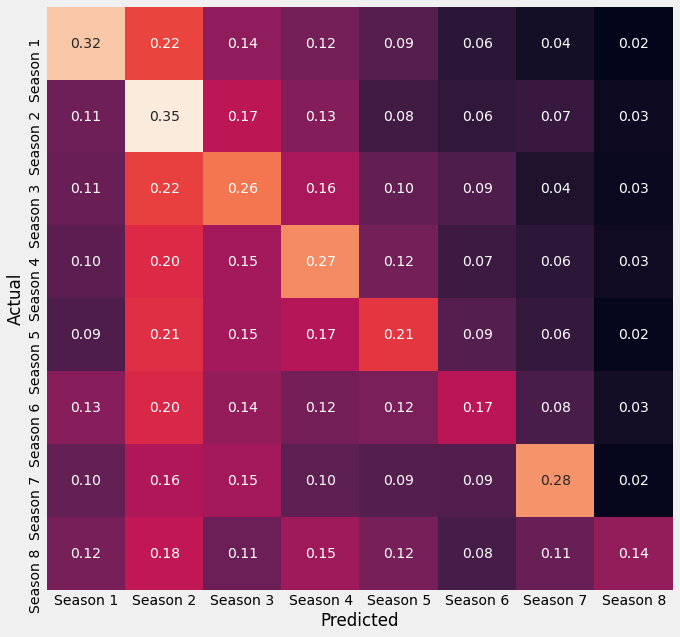

In [105]:
clf.plot_cm(y_test, y_pred, normalized=True)

__Cross-validation___

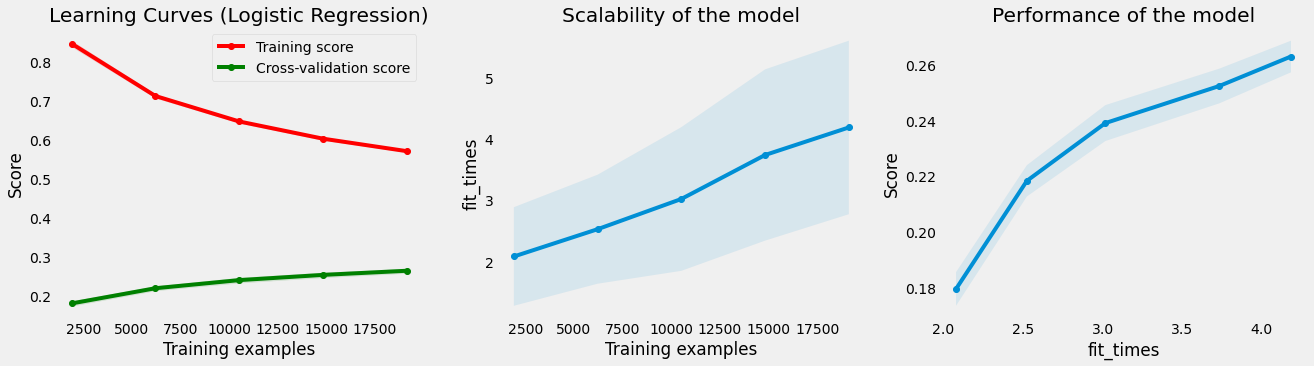

In [106]:
X_vect = vectorizer.fit_transform(sentences)

title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

model = LogisticRegression(random_state=42)
clf.plot_learning_curve(model, title, X_vect, labels, cv=cv, n_jobs=4)

## DEEP NEURAL NETWORK

### Model 1

__Binarize labels__

In [130]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

__Create Word Embeddings__

In [131]:
tokenizer = Tokenizer(num_words=5000)

tokenizer.fit_on_texts(X_train)

X_train_toks = tokenizer.texts_to_sequences(X_train)
X_test_toks = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

__Padding__

In [132]:
maxlen = 100

X_train_pad = pad_sequences(X_train_toks, 
                            padding='post',
                            maxlen=maxlen)

X_test_pad = pad_sequences(X_test_toks, 
                           padding='post', 
                           maxlen=maxlen)

__Define model architecture__

In [133]:
embedding_dim = 100
l2 = L2(0.0001)

model = Sequential()

model.add(Embedding(input_dim=vocab_size,     
                    output_dim=embedding_dim, 
                    input_length=maxlen))    

model.add(Conv1D(128, 5,
                 activation='relu',
                 kernel_regularizer=l2))

model.add(GlobalMaxPool1D())

model.add(Dense(10, activation='relu', 
                kernel_regularizer=l2))

model.add(Dense(8, 
                activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          896400    
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 88        
Total params: 961,906
Trainable params: 961,906
Non-trainable params: 0
_________________________________________________________________


__Train and evaluate__

In [134]:
history = model.fit(X_train_pad, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test_pad, y_test),
                    batch_size=10)

In [135]:
loss, accuracy = model.evaluate(X_train_pad, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9048
Testing Accuracy:  0.2260


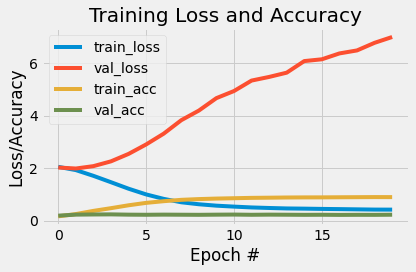

In [136]:
plot_history(history, epochs=20)

### Model 4

__Use Pretrained Word Embeddings__

In [139]:
tf.keras.backend.clear_session()

In [ ]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip -q glove.6B.zip

In [138]:
embedding_matrix = create_embedding_matrix('../glove/glove.6B.100d.txt',
                                           tokenizer.word_index,
                                           embedding_dim)

In [140]:
embedding_dim = 100
l2 = L2(0.0001)

model = Sequential()
model.add(Embedding(vocab_size, 
                    embedding_dim, 
                    weights=[embedding_matrix],  
                    input_length=maxlen, 
                    trainable=False))
model.add(Conv1D(128, 5,
                 activation='relu',
                 kernel_regularizer=l2))
model.add(GlobalMaxPool1D())
model.add(Dense(10,
                activation='relu',
                kernel_regularizer=l2))
model.add(Dense(8, 
                activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          896400    
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 88        
Total params: 961,906
Trainable params: 65,506
Non-trainable params: 896,400
_________________________________________________________________


Training Accuracy: 0.4197
Testing Accuracy:  0.1827


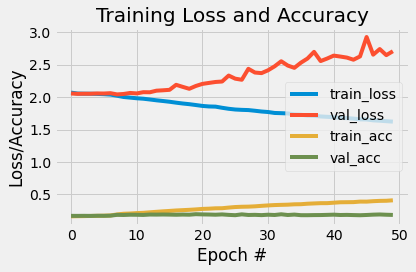

In [141]:
history = model.fit(X_train_pad, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test_pad, y_test),
                    batch_size=10)

loss, accuracy = model.evaluate(X_train_pad, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


plot_history(history, epochs = 50)

### Model 5

__Retraining the GloVe embeddings__

In [142]:
embedding_dim = 100
l2 = L2(0.0001)

model = Sequential()

model.add(Embedding(vocab_size, 
                    embedding_dim, 
                    weights=[embedding_matrix],
                    input_length=maxlen, 
                    trainable=True))           
model.add(Conv1D(128, 5,
                 activation='relu',
                 kernel_regularizer=l2))
model.add(GlobalMaxPool1D())
model.add(Dense(10,
                activation='relu',
                kernel_regularizer=l2))
model.add(Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Training Accuracy: 0.8165
Testing Accuracy:  0.2171


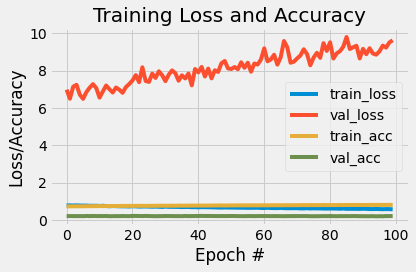

In [145]:
history = model.fit(X_train_pad, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test_pad, y_test),
                    batch_size=10)

# evaluate 
loss, accuracy = model.evaluate(X_train_pad, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

# plot
plot_history(history, epochs = 50)